In [1]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations, product
import pandas as pd
import json
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm
from scipy.ndimage.measurements import label
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
#     assert X.shape[1:] == Y.shape[1:], f'{X.shape}, {Y.shape}'
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
#     assert result.shape[0] == X.shape[0] and result.shape[1] == Y.shape[0], result.shape
    return result

In [3]:
class MyKNNFilter:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def gaussian_weight(self, distance):
        sigma = self.n_neighbors // 3
        return np.exp(-np.power(distance, 2) / (2 * sigma**2))
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            pairs_idx_dist = sorted(enumerate(pair_distance[test_idx]), key=lambda x: x[1])[:self.n_neighbors]
            chosen_indices = [x[0] for x in pairs_idx_dist]
            
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for idx, chosen_idx in enumerate(chosen_indices):
                weighted_results += (1. / np.sqrt(idx + 1)) * self.y[chosen_idx]  # self.gaussian_weight(idx) *
            output.append(weighted_results)
        return np.array(output)


class MyGaussianFilter:
    def __init__(self, sigma=0.05, min_neighbors=3):
        self.sigma = sigma
        self.min_neighbors = min_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            if len(chosen_indices) < self.min_neighbors:
                chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)
    
class MyMixedFilter:
    def __init__(self, sigma=0.05, n_neighbors=10):
        self.sigma = sigma
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def gaussian_weight(self, distance, sigma):
        return np.exp(-np.power(distance, 2) / (2 * sigma**2))
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
                    
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            if len(chosen_indices) > self.n_neighbors:
                gaussian_weights = self.gaussian_weight(pair_distance[test_idx], self.sigma)
            else:
                pairs_idx_dist = sorted(enumerate(pair_distance[test_idx]), key=lambda x: x[1])[:self.n_neighbors]
                chosen_indices = [x[0] for x in pairs_idx_dist]
                sigma = pairs_idx_dist[self.n_neighbors-1][1]/3
                gaussian_weights = self.gaussian_weight(pair_distance[test_idx], sigma)
                
            sum_weights = np.sum([gaussian_weights[chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
                
        return np.array(output)

In [4]:
def knn_on_points(X, y, n_neighbors):
    knn = MyKNNFilter(n_neighbors=n_neighbors)
    knn.fit(X, y)
    return knn.predict(X)

def filter_on_points(X, y, sigma):
    knn = MyGaussianFilter(sigma=sigma)
    knn.fit(X, y)
    return knn.predict(X)

def mixed_on_points(X, y, sigma, n_neighbors):
    knn = MyMixedFilter(sigma=sigma, n_neighbors=n_neighbors)
    knn.fit(X, y)
    return knn.predict(X)

def filter_grid(X, y, sigma=0.05, resolution=11):
    dim = X.shape[1]
    
    knn = MyGaussianFilter(sigma=sigma)
    knn.fit(X, y)
    
    mins = np.min(X, axis=0)
    widths = np.max(X, axis=0) - np.min(X, axis=0)
    
    arr = np.zeros([resolution] * dim, dtype=np.float32)  # y_pred in nd
    for point in tqdm(product(*[range(resolution) for _ in range(dim)]), total=resolution ** dim):
        pred = knn.predict((np.array(point) / resolution * widths + mins)[None])[0]
        if ~np.all(pred == 0):
            if np.sum(pred == np.max(pred)):
                arr[point] = np.argmax(pred)
            else:
                arr[point] = -1
        else:
            arr[point] = -1
    
    return arr

In [5]:
def prepare_plot_knn(X, y, n_neighbors=1, resolution=101):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(0, 1, resolution)):
        for yidx, yval in enumerate(np.linspace(0, 1, resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return plot

def prepare_plot_filter(X, y, sigma=0.05, resolution=100, min_neighbors=3):
    knn = MyGaussianFilter(sigma=sigma, min_neighbors=min_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(0, 1, resolution)):
        for yidx, yval in enumerate(np.linspace(0, 1, resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return plot

In [6]:
def point2plot(x, feature_name, resolution=100):
    vmin, vmax = 0, 1
    return (x - vmin) / (vmax - vmin) * resolution

def doplot(ax, X, y, plot, feature_names, resolution=100, scatter=True):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2
    try:
        ax.set_xticks(np.linspace(0, resolution, n_ticks))
        ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(feature_min[feature_names[1]], feature_max[feature_names[1]], n_ticks)], rotation='vertical');
    except:
        pass
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2
    try:
        ax.set_yticks(np.linspace(0, resolution, n_ticks))
        ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(feature_min[feature_names[0]], feature_max[feature_names[0]], n_ticks)]);
    except:
        pass
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    if scatter:
        ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=0.05, c='black')

# 5d filter

In [7]:
kernels_order = np.array([x.name for x in kernels])
list(enumerate(kernels_order));

In [8]:
allowed_kernels = [
    'SCCT',
    'NHeat',
    'Comm',
    'logComm',
    'RSP',
    'logDF'
]

In [9]:
# root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr_simple'
# dataset = []
# for fn in tqdm(os.listdir(root)):
#     with open(f'{root}/{fn}', 'rb') as f:
#         dataset.append(json.load(f))
        
with open('filtered_dataset.json', 'r') as f:
    dataset = json.load(f)
print(len(dataset))
    
idx_several_answers = [idx for idx, d in enumerate(dataset) 
                       if np.sum(np.max(np.array(list(d['measure_best_results'].values()))) == np.array(list(d['measure_best_results'].values()))) > 1]
idx_several_answers = set(idx_several_answers)

dataset = [d for idx, d in enumerate(dataset) if idx not in idx_several_answers]

dataset = [d for d in dataset if np.max(list(d['measure_best_results'].values())) > 0]
print(len(dataset))

7396
5476


In [10]:

Counter([sorted(list(dataset[i]['measure_best_results'].items()), key=lambda x: -x[1])[0][0] for i in range(len(dataset))]).most_common()

[('SCCT', 2781),
 ('NHeat', 853),
 ('Comm', 281),
 ('logComm', 258),
 ('RSP', 186),
 ('logDF', 168),
 ('SCT', 157),
 ('SP-CT', 133),
 ('logKatz', 128),
 ('Abs', 88),
 ('DF', 70),
 ('Katz', 55),
 ('FE', 47),
 ('Heat', 42),
 ('logFor', 42),
 ('logHeat', 39),
 ('logPPR', 32),
 ('logModifPPR', 26),
 ('HeatPR', 24),
 ('PPR', 20),
 ('logHeatPR', 12),
 ('logNHeat', 11),
 ('logAbs', 11),
 ('ModifPPR', 6),
 ('For', 6)]

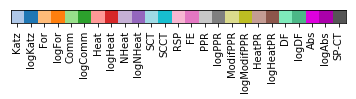

In [11]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

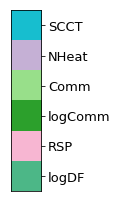

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))

a = np.zeros((6, 1, 3), dtype=np.uint8)
labels = []
for idx, kernel_name in enumerate(allowed_kernels):
    a[idx, 0] = np.array(colors.to_rgb(d3_colors[kernel_name])) * 255
    labels.append(kernel_name)
plt.imshow(a)
plt.yticks(range(6), labels)
plt.xticks([]);
ax.yaxis.tick_right()
plt.tight_layout()
plt.savefig('pics/legend.pdf', bbox_inches='tight')

In [12]:
all_feature_names = [
    'n',
    'tau1|sqrtinv',
    'tau2|sqrtinv',
    'avg_degree|log',
#     'avg_density',
    'modularity'
#     'mu'
]

useful_feature_names = [
    'tau1|sqrtinv',
    'avg_degree|log',
    'modularity'
]

feature_min = {fn: np.min([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_max = {fn: np.max([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_width = {fn: feature_max[fn] - feature_min[fn] for fn in all_feature_names}
feature_dispersion = {fn: np.std([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_normalize = lambda x, fn: (x - feature_min[fn]) / feature_width[fn]
feature_normalize2 = lambda x, fn: (x - feature_min[fn]) / feature_dispersion[fn]

for fn in all_feature_names:
    print(f'{fn}: {feature_min[fn]:.2f}, {feature_max[fn]:.2f} | '
          f'{feature_normalize(feature_min[fn], fn):.2f}, {feature_normalize(feature_max[fn], fn):.2f}')

n: 10.00, 1499.00 | 0.00, 1.00
tau1|sqrtinv: 0.27, 0.94 | 0.00, 1.00
tau2|sqrtinv: 0.19, 0.97 | 0.00, 1.00
avg_degree|log: 0.86, 7.07 | 0.00, 1.00
modularity: -0.46, 0.84 | 0.00, 1.00


## LDA

In [13]:
X = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in all_feature_names] for item in dataset])
y = np.array([[item['measure_best_results'][kernel] for kernel in kernels_order] for item in dataset])

In [14]:
pca = LinearDiscriminantAnalysis(n_components=None)
X_new = pca.fit_transform(X, np.argmax(y, axis=1))

In [15]:
X_new.shape

(5476, 5)

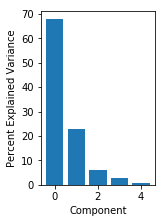

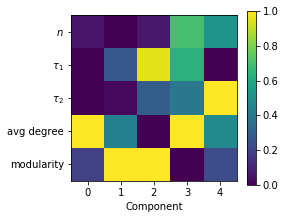

In [16]:
def plot_lda_importance(X_new):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#     ax[0].bar(range(len(pca.explained_variance_ratio_)), np.array(pca.explained_variance_ratio_) * 100)
#     ax[0].set_xlabel('Component')
#     ax[0].set_ylabel('Percent Explained Variance')
    

#     img = np.abs(pca.transform(np.eye(len(all_feature_names))) - pca.transform(np.zeros((1, len(all_feature_names)))))
#     img = (img - np.min(img, axis=0, keepdims=True)) / (np.max(img, axis=0, keepdims=True) - np.min(img, axis=0, keepdims=True))
#     ia = ax[1].imshow(img)
#     ax[1].set_xticks(range(0, 2))
#     ax[1].set_yticks(range(len(all_feature_names)));
#     ax[1].set_yticklabels(all_feature_names)
#     ax[1].set_xlabel('Component')

#     plt.tight_layout()
#     fig.colorbar(ia, ax=ax);

    fig, ax = plt.subplots(1, 1, figsize=(3*0.8, 4*0.8))
    ax.bar(range(len(pca.explained_variance_ratio_)), np.array(pca.explained_variance_ratio_) * 100)
    ax.set_xlabel('Component')
    ax.set_ylabel('Percent Explained Variance')
    plt.tight_layout();
    plt.plot()
    plt.savefig('pics/lda_component_ratio.pdf')
    
    
    fig, ax = plt.subplots(1, 1, figsize=(5*0.8, 4*0.8))
    img = np.abs(pca.transform(np.eye(len(all_feature_names))) - pca.transform(np.zeros((1, len(all_feature_names)))))
    img = (img - np.min(img, axis=0, keepdims=True)) / (np.max(img, axis=0, keepdims=True) - np.min(img, axis=0, keepdims=True))
    ia = ax.imshow(img)
    ax.set_xticks(range(0, 5))
    ax.set_yticks(range(len(all_feature_names)));
    ax.set_yticklabels([r'$n$', r'$\tau_1$', r'$\tau_2$', 'avg degree', 'modularity'])
    ax.set_xlabel('Component')
    fig.colorbar(ia, ax=ax);
    plt.tight_layout();
    plt.plot()
    plt.savefig('pics/lda_feature_importance.pdf')

    
plot_lda_importance(X_new)

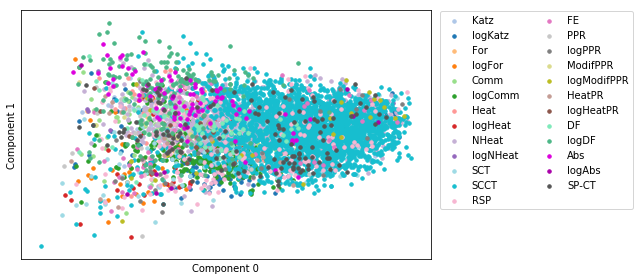

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for kernel_idx, kernel_name in enumerate(kernels_order):
    kernel_mask = np.argmax(y, axis=1) == kernel_idx
    plt.scatter(X_new[kernel_mask][:, 0], X_new[kernel_mask][:, 1], s=12, c=d3_colors[kernel_name], label=kernel_name)
    plt.xlabel('Component 0')
    plt.ylabel('Component 1')
    
# plt.xlim(-4, 4.2)
plt.legend(bbox_to_anchor=(1.01, 1.015), loc='upper left', ncol=2,)

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
    
# plt.legend(loc=1)
plt.savefig('pics/pointcloud.pdf')

## Filter 3d space

0.22953144655641303


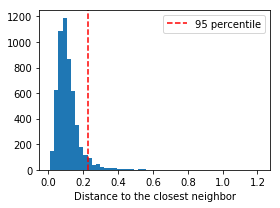

In [18]:
def calc_min_distance(dataset):
    X = np.array([[feature_normalize2(item['estimated_params'][fname], fname) for fname in useful_feature_names] for item in dataset])

    pair_distance = euclidean_distances(X, X)
    np.fill_diagonal(pair_distance, 9999)
    min_distance = np.min(pair_distance, axis=1)
    return min_distance

fig, ax = plt.subplots(1, figsize=(4, 3))
min_distance = calc_min_distance(dataset)
plt.hist(min_distance, bins=50)

plt.xlabel('Distance to the closest neighbor')

plt.axvline(np.percentile(min_distance, 95), 0, 1, label='95 percentile', c='red', linestyle='--')


plt.legend()
plt.tight_layout()

plt.savefig('pics/3d_neighbor_distance.pdf')

print(np.percentile(min_distance, 95))

In [19]:
dataset = [item for item, dist in zip(dataset, min_distance) if dist < np.percentile(min_distance, 95)]
len(dataset)

5201

array([0.21466069, 0.09668494, 0.06701413, ..., 0.0852269 , 0.15213274,
       0.10424903])

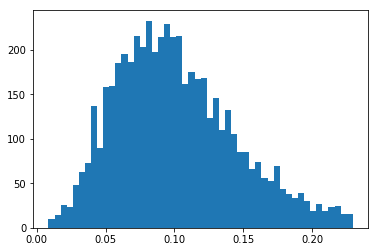

In [20]:
X = np.array([[feature_normalize2(item['estimated_params'][fname], fname) for fname in useful_feature_names] for item in dataset])

pair_distance = euclidean_distances(X, X)
np.fill_diagonal(pair_distance, 9999)
min_distance = np.min(pair_distance, axis=1)
plt.hist(min_distance, bins=50);
min_distance

## Choosing sigma

## Filter in 5d

In [21]:
X = np.array([[feature_normalize2(item['estimated_params'][fname], fname) for fname in useful_feature_names] for item in dataset])
y = np.array([[item['measure_best_results'][kernel] for kernel in kernels_order] for item in dataset])
for idx, kernel_name in enumerate(kernels_order):
    if kernel_name not in allowed_kernels:
        y[:, idx] = -1

In [22]:
y_pred = filter_on_points(X, y, 0.50)
# y_pred = knn_on_points(X, y, 40)
# y_pred = mixed_on_points(X, y, 0.60, 50)
y_pred = np.argmax(y_pred, axis=1)
y_pred = kernels_order[y_pred]
Counter(y_pred).most_common()

[('SCCT', 4288),
 ('logComm', 439),
 ('NHeat', 269),
 ('Comm', 82),
 ('logDF', 64),
 ('RSP', 59)]

## All 2d projections

('tau1|sqrtinv', 'avg_degree|log')
('tau1|sqrtinv', 'modularity')
('avg_degree|log', 'modularity')


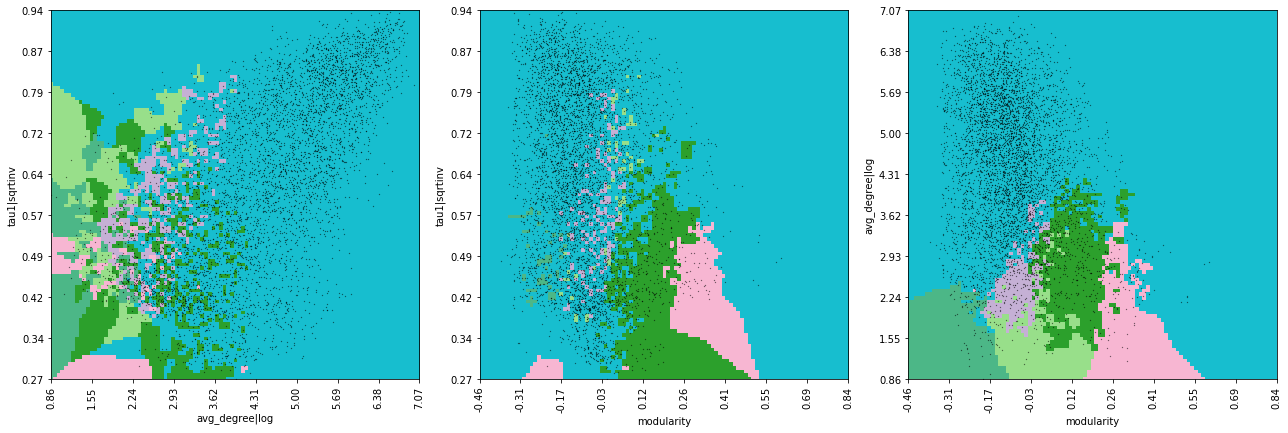

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax = np.array(ax).ravel()

for idx, feature_names in enumerate(combinations(useful_feature_names, 2)):
    print(feature_names)
    
    XXX = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in feature_names] for item in dataset])
    plot = prepare_plot_knn(XXX, y_pred)
    doplot(ax[idx], XXX, y, plot, feature_names)
    
plt.tight_layout()

## Grid

In [24]:
arr = filter_grid(X, y, sigma=0.3, resolution=21)

In [25]:
def flatten_3d(X, arr):
    dim = X.shape[1]
    resolution = arr.shape[0]
    mins = np.min(X, axis=0)
    widths = np.max(X, axis=0) - np.min(X, axis=0)
    
    out_x, out_y = [], []
    for point in tqdm(product(*[range(resolution) for _ in range(dim)]), total=resolution ** dim):
        if arr[point] != -1:
            out_x.append(np.array(point) / resolution ) # * widths + mins
            out_y.append(kernels_order[int(arr[point])])
    return np.array(out_x), np.array(out_y)

In [26]:
out_x, out_y = flatten_3d(X, arr)

In [27]:
out_x.shape, out_y.shape

((6518, 3), (6518,))

In [28]:
mins = np.min(out_x, axis=0)
widths = np.max(out_x, axis=0) - np.min(out_x, axis=0)
mins, widths

(array([0., 0., 0.]), array([0.95238095, 0.95238095, 0.95238095]))

In [29]:
tau1_01 = lambda x: (x - feature_min["tau1|sqrtinv"]) / feature_width["tau1|sqrtinv"] * 100
adeg_01 = lambda x: (x - feature_min["avg_degree|log"]) / feature_width["avg_degree|log"] * 100
mod_01 = lambda x: (x - feature_min["modularity"]) / feature_width["modularity"] * 100
feature_inv = lambda x, power: (1 - (1 / x**power))
invinv = lambda x: 1 / (1-x)**2

In [63]:
import matplotlib

SMALL_SIZE = 13
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

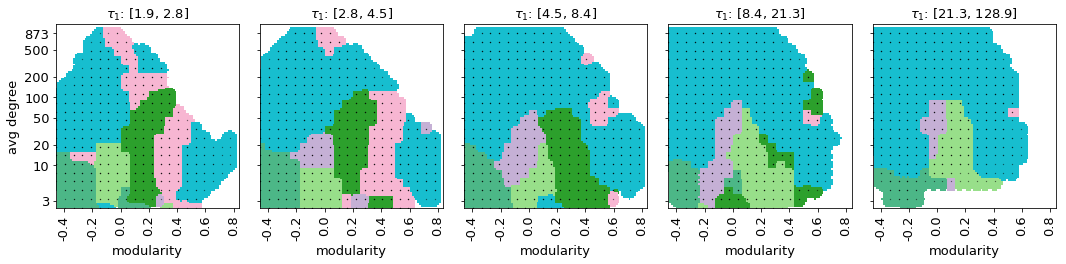

In [80]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3.8), sharey=True)

feature_num_to_slice = 0
feature_names = ['avg_degree|log', 'modularity']
for ii in range(5):
    min_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * ii
    max_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * (ii + 1)
    
    foutxy = [(x, y) for x, y in zip(out_x, out_y) if min_feature < x[0] < max_feature]
    foutx, fouty = np.array([x for x, y in foutxy]), np.array([y for x, y in foutxy])
    
    kernels_order_list = kernels_order.tolist()
    y_pred_index = [kernels_order_list.index(item) for item in fouty]
    y_pred_onehot = np.zeros((len(y_pred), 25), dtype=np.uint8)
    for i in range(len(fouty)):
        y_pred_onehot[i][y_pred_index[i]] = 1
    
    plot = prepare_plot_filter(foutx[:, 1:], y_pred_onehot, sigma=0.015, min_neighbors=1)
    doplot(ax[ii], foutx[:, 1:], fouty, plot, feature_names)
    
    left_border = min_feature*feature_width["tau1|sqrtinv"]+feature_min["tau1|sqrtinv"]
    left_border = invinv(left_border)
    right_border = max_feature*feature_width["tau1|sqrtinv"]+feature_min["tau1|sqrtinv"]
    right_border = invinv(right_border)
    ax[ii].set_title(f'$\\tau_1$: [{left_border:.1f}, {right_border:.1f}]')
    
    ax[ii].set_ylabel('')
    
    mod_legend = [-.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ax[ii].set_xticks([mod_01(x) for x in mod_legend])
    ax[ii].set_xticklabels(mod_legend)
    
ax[0].set_ylabel('avg degree')

adeg_legend = [3, 10, 20, 50, 100, 200, 500, 873]
ax[0].set_yticks([adeg_01(np.log(x)) for x in adeg_legend])
ax[0].set_yticklabels(adeg_legend)

plt.tight_layout()
plt.savefig('pics/splits_by_tau1.pdf')

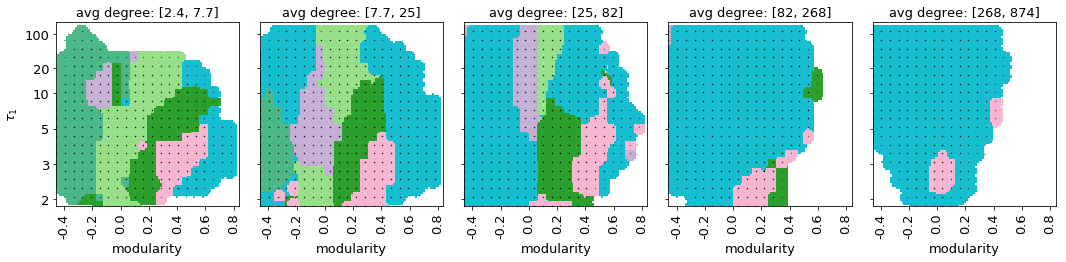

In [81]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3.8), sharey=True)

feature_num_to_slice = 1
feature_names = ['tau1|sqrtinv', 'modularity']
for ii in range(5):
    min_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * ii
    max_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * (ii + 1)
    
    foutxy = [(x, y) for x, y in zip(out_x, out_y) if min_feature < x[feature_num_to_slice] < max_feature]
    foutx, fouty = np.array([x for x, y in foutxy]), np.array([y for x, y in foutxy])
    
    kernels_order_list = kernels_order.tolist()
    y_pred_index = [kernels_order_list.index(item) for item in fouty]
    y_pred_onehot = np.zeros((len(y_pred), 25), dtype=np.uint8)
    for i in range(len(fouty)):
        y_pred_onehot[i][y_pred_index[i]] = 1
    
    plot = prepare_plot_filter(foutx[:, (0, 2)], y_pred_onehot, sigma=0.015, min_neighbors=1)
    doplot(ax[ii], foutx[:, (0, 2)], fouty, plot, feature_names)
    
    left_border = min_feature*feature_width["avg_degree|log"]+feature_min["avg_degree|log"]
    left_border = np.exp(left_border)
    right_border = max_feature*feature_width["avg_degree|log"]+feature_min["avg_degree|log"]
    right_border = np.exp(right_border)
    if left_border < 10:
        if right_border > 10:
            ax[ii].set_title(f'avg degree: [{left_border:.1f}, {right_border:.0f}]')
        else:
            ax[ii].set_title(f'avg degree: [{left_border:.1f}, {right_border:.1f}]')
    else:
        ax[ii].set_title(f'avg degree: [{left_border:.0f}, {right_border:.0f}]')
        
    
    ax[ii].set_ylabel('')
    
    mod_legend = [-.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ax[ii].set_xticks([mod_01(x) for x in mod_legend])
    ax[ii].set_xticklabels(mod_legend)
    
ax[0].set_ylabel(r'$\tau_1$')

tau1_legend = [2, 3, 5, 10, 20, 100]
ax[0].set_yticks([tau1_01(feature_inv(x, 0.5)) for x in tau1_legend])
ax[0].set_yticklabels(tau1_legend)

plt.tight_layout()
plt.savefig('pics/splits_by_avg_degree.pdf')

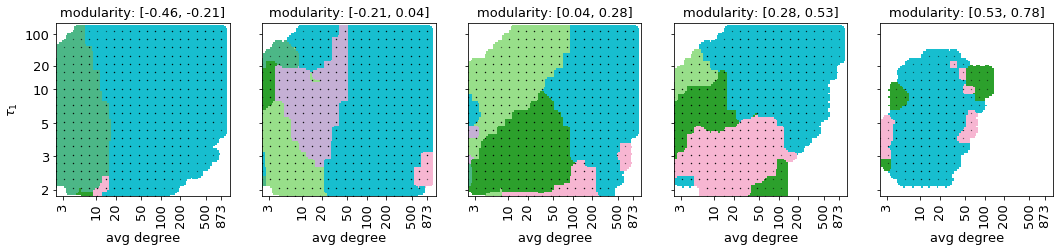

In [82]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3.8), sharey=True)

feature_num_to_slice = 2
feature_names = ['tau1|sqrtinv', 'avg_degree|log']
for ii in range(5):
    min_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * ii
    max_feature = mins[feature_num_to_slice] + (widths[feature_num_to_slice] / 5) * (ii + 1)
    
    foutxy = [(x, y) for x, y in zip(out_x, out_y) if min_feature < x[feature_num_to_slice] < max_feature]
    foutx, fouty = np.array([x for x, y in foutxy]), np.array([y for x, y in foutxy])
    
    kernels_order_list = kernels_order.tolist()
    y_pred_index = [kernels_order_list.index(item) for item in fouty]
    y_pred_onehot = np.zeros((len(y_pred), 25), dtype=np.uint8)
    for i in range(len(fouty)):
        y_pred_onehot[i][y_pred_index[i]] = 1
    
    plot = prepare_plot_filter(foutx[:, :2], y_pred_onehot, sigma=0.015, min_neighbors=1)
    doplot(ax[ii], foutx[:, :2], fouty, plot, feature_names)
        
    left_border = min_feature*feature_width["modularity"]+feature_min["modularity"]
    right_border = max_feature*feature_width["modularity"]+feature_min["modularity"]
    ax[ii].set_title(f'modularity: [{left_border:.2f}, {right_border:.2f}]')
    
    ax[ii].set_ylabel('')

    ax[ii].set_xlabel('avg degree')

    adeg_legend = [3, 10, 20, 50, 100, 200, 500, 873]
    ax[ii].set_xticks([adeg_01(np.log(x)) for x in adeg_legend])
    ax[ii].set_xticklabels(adeg_legend)
    
    
ax[0].set_ylabel(r'$\tau_1$')

tau1_legend = [2, 3, 5, 10, 20, 100]
ax[0].set_yticks([tau1_01(feature_inv(x, 0.5)) for x in tau1_legend])
ax[0].set_yticklabels(tau1_legend)

plt.tight_layout()
plt.savefig('pics/splits_by_modularity.pdf')